Notwenige Importe und Konfigurationsfile

In [1]:
import sys
sys.path.append("src")  # Falls noch nicht gesetzt

from audio_data import AudioDataSet
from feature_set import FeatureSet
from drone_classifier import DroneClassifier

config = {
    "sample_rate": 16000,
    "audio_length": 1, # in Sekunden
    "train_path": "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/TRAINING/",
    "val_path":   "d:/Dropbox/03 H2 Think/AuDroK mFund/Auswertungen/Datensätze/Drone vs. No Drone/VALIDATION/",
    "model_file": "models/classifier_001.keras",
    "feature_files": {
        "train_features": "models/train_features.pkl",
        "val_features": "models/val_features.pkl",
        "train_labels": "models/train_labels.pkl",
        "val_labels": "models/val_labels.pkl"
    }
}

Rohdaten fürs Training laden

Pre-Emphasis anwenden

chunken

Normalisieren

In [6]:
# Laden des Audiodatensatzes für die Trainingsdaten
raw_data_train = AudioDataSet.from_path(
    path=config["train_path"],
    sample_rate=config["sample_rate"]
)

# Apply Pre-Emphasis auf die Trainingsrohdaten
for audio in raw_data_train.audio:
    audio.apply_pre_emphasis()

# Chunken der Trainingsrohdaten
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data_train = raw_data_train.chunk_all(chunk_length)
print(f"{len(chunked_data_train.audio)} Chunks")


Processing audio files (3266 files to process):
[#######################################.] 99.48%
39171 Chunks


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrum(signal, sample_rate, title="Spektrum", fmin=10, fmax=1000):
    from scipy.signal import welch
    freqs, psd = welch(signal, fs=sample_rate, nperseg=2048)
    plt.figure(figsize=(10, 3))
    plt.loglog(freqs, psd)
    plt.title(title)
    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Leistungsspektral­dichte")
    plt.xlim(fmin, fmax)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

chunk_number = 1234

signal = chunked_data_train.audio[chunk_number]
signal.plot()

plot_spectrum(signal.signal, config["sample_rate"])

chunk_number = 2345

signal = chunked_data_train.audio[chunk_number]
signal.plot()

plot_spectrum(signal.signal, config["sample_rate"])

In [7]:
# Normalisierung der Trainingsrohdaten
for audio in chunked_data_train.audio:
    audio.apply_rms_normalization(target_rms=0.1)

# Zwischenspeichern der Trainingsdaten zur Vereinfachung des Debuggings
import pickle

with open("chunked_data_train.pkl", "wb") as f:
    pickle.dump(chunked_data_train, f)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_spectrum(signal, sample_rate, title="Spektrum", fmin=10, fmax=1000):
    from scipy.signal import welch
    freqs, psd = welch(signal, fs=sample_rate, nperseg=2048)
    plt.figure(figsize=(10, 3))
    plt.loglog(freqs, psd)
    plt.title(title)
    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Leistungsspektral­dichte")
    plt.xlim(fmin, fmax)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

chunk_number = 1234

signal = chunked_data_train.audio[chunk_number]
signal.plot()

plot_spectrum(signal.signal, config["sample_rate"])

chunk_number = 2345

signal = chunked_data_train.audio[chunk_number]
signal.plot()

plot_spectrum(signal.signal, config["sample_rate"])

Laden der zwischengespeicherten Gechunkten und vorverarbeiteten Trainingsdaten

In [2]:
# Laden
import pickle

with open("chunked_data_train.pkl", "rb") as f:
    chunked_data_train = pickle.load(f)

Augmentieren der TRainingsdaten durch das Hinzufügen einer Bodenreflexion

In [9]:
from augmentations import apply_ground_reflection_to_dataset
import numpy as np

ranges = {
    "src_x": (-10, 10),
    "src_y": (-10, 10),
    "src_z": (1, 5),
    "mic_z": (1, 2),
    "attenuation": (0.05, 0.95)
}

np.random.seed()

augmented_train_data = apply_ground_reflection_to_dataset(
    dataset=chunked_data_train,
    sample_rate=config["sample_rate"],
    ranges=ranges
)

Augmentieren der Trainingsdaten durch das Mixen mit Umgebungslärm

In [ ]:
from augmentations import apply_noise_augmentation

# Nur Drone-Signale auswählen
drone_signals = [audio for audio in chunked_data_train.audio if audio.label == "drone"]
no_drone_signals = [audio for audio in chunked_data_train.audio if audio.label == "no drone"]

from audio_data import AudioDataSet
drone_dataset = AudioDataSet(drone_signals)
noise_dataset = AudioDataSet(no_drone_signals)

# Augmentieren mit max. SNR von -6 dB
augmented_noise_data = apply_noise_augmentation(drone_dataset, noise_dataset, sample_rate=config["sample_rate"], max_snr_db=-6)


Rohdaten für die Validierung laden

Pre-Emphasis anwenden

chunken

Normalisieren

Zwischenspeichern

In [10]:
raw_data_val = AudioDataSet.from_path(
    path=config["val_path"],
    sample_rate=config["sample_rate"]
)

# Pre-Emphasis
for audio in raw_data_val.audio:
    audio.apply_pre_emphasis()

# Chunken
chunk_length = config["sample_rate"] * config["audio_length"]
chunked_data_val = raw_data_val.chunk_all(chunk_length)
print(f"{len(chunked_data_val.audio)} Chunks")



Processing audio files (277 files to process):
[####################################....] 92.42%
34211 Chunks


In [11]:
# Normalisierung der Trainingsrohdaten
for audio in chunked_data_val.audio:
    audio.apply_rms_normalization(target_rms=0.1)

# Zwischenspeichern der vorverarbeiteten Validierungsdaten
import pickle

with open("chunked_data_val.pkl", "wb") as f:
    pickle.dump(chunked_data_val, f)

Laden der zwischengespeicherten vorverarbeiteten Validierungsdaten

In [7]:
# Laden
import pickle

with open("chunked_data_val.pkl", "rb") as f:
    chunked_data_val = pickle.load(f)

Feature Extraction

In [12]:
# Feature-Extraktion
train_features = FeatureSet(augmented_train_data, sample_rate=config["sample_rate"])
X_train, y_train = train_features.extract()

val_features = FeatureSet(chunked_data_val, sample_rate=config["sample_rate"])
X_val, y_val = val_features.extract()

Processing features (39171 files to process):
[########################################] 100.00%
Processing features (34211 files to process):
[########################################] 100.00%


Zwischenspeichern der Features zur Vereinfachung des Debuggings (funktioniert derzeit nicht korrekt, beim Laden ändert sich das Format)

In [11]:
# Speichern
import pickle

with open("features.pkl", "wb") as f:
    pickle.dump({
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val
    }, f)

In [3]:
# Laden
import pickle

with open("features.pkl", "rb") as f:
    data = pickle.load(f)

X_train = data["X_train"]
y_train = data["y_train"]
X_val = data["X_val"]
y_val = data["y_val"]

Modelltraining & Evaluation

Encoded Labels - Train: [0 1]
Encoded Labels - Validation: [0 1]
Class weights: {0: np.float64(0.559138403562864), 1: np.float64(4.727371469949312)}
Epoch 1/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 730s 1s/step - accuracy: 0.8620 - loss: 1.6876 - val_accuracy: 0.6296 - val_loss: 0.1689 - learning_rate: 5.0000e-04
Epoch 2/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 678s 1s/step - accuracy: 0.9732 - loss: 0.0593 - val_accuracy: 0.7442 - val_loss: 0.0795 - learning_rate: 5.0000e-04
Epoch 3/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9788 - loss: 0.2059 - val_accuracy: 0.5055 - val_loss: 0.2403 - learning_rate: 5.0000e-04
Epoch 4/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 712s 1s/step - accuracy: 0.9792 - loss: 0.0704 - val_accuracy: 0.5878 - val_loss: 0.1747 - learning_rate: 5.0000e-04
Epoch 5/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 756s 1s/step - accuracy: 0.9855 - loss: 0.0735 - val_accuracy: 0.4785 - val_loss: 0.3824 - learning_rate: 5.0000e-04
Epoch 6/30
613/613 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0

1070/1070 ━━━━━━━━━━━━━━━━━━━━ 327s 305ms/step
Erstellen eines Plots für die Konfusionsmatrix
Normalisierte Konfusionsmatrix (in Prozent):
[[99.55905512  0.44094488]
 [99.29027679  0.70972321]]
Anpassen der Achsenbeschriftung der Konfusionsmatrix
Speichern des Plots für die Konfusionsmatrix


TypeError: unsupported format string passed to NoneType.__format__

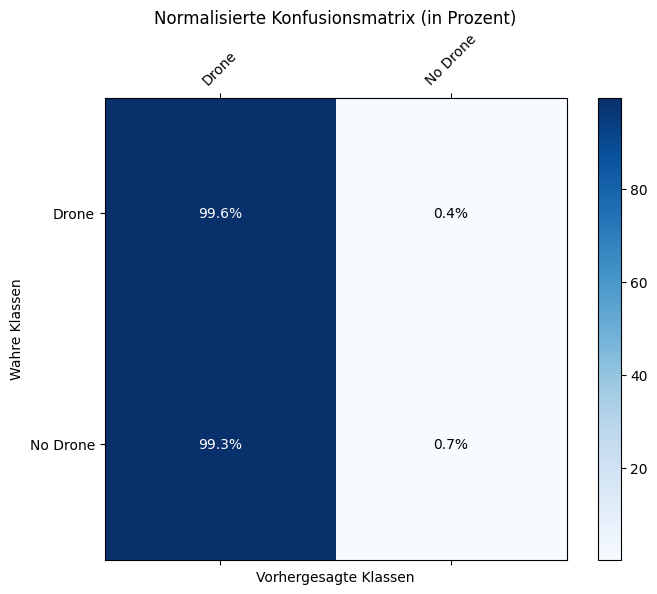

In [13]:
model = DroneClassifier(model_path="models/classifier_007.h5", trainable_layers=5)
model.train(X_train, y_train, X_val, y_val)
accuracy = model.evaluate(X_val, y_val)

print(f"Validierungsgenauigkeit: {accuracy:.2%}")